In [4]:
# Use GPU for Theano, comment to use CPU instead of GPU
# Tensorflow uses GPU by default
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"

In [5]:
# If using tensorflow, set image dimensions order
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

/home/lntk/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [6]:
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.datasets import mnist # subroutines for fetching the MNIST dataset
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Dense, Flatten, Convolution2D, MaxPooling2D, Dropout, average
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
from keras.regularizers import l2 # L2-regularisation
from keras.layers.normalization import BatchNormalization # batch normalisation
from keras.preprocessing.image import ImageDataGenerator # data augmentation
from keras.callbacks import EarlyStopping # early stopping

In [7]:
# Tải dữ liệu Cifar10 từ Keras và chia thành dữ liệu huấn luyện và kiểm tra.
from keras.datasets import cifar10

# Dũ liệu CIFAR10 gồm 50,000 ảnh màu kích thước 32x32 để huấn luyện, gồm 10 chuyên mục, và 10,000 ảnh kiểm tra.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Get the info of the training data
num_train, height, width, depth =  X_train.shape
num_test, _, _, _ =  X_test.shape
num_classes = len(np.unique(y_train))

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Training data shape: ', (50000, 32, 32, 3))
('Training labels shape: ', (50000, 1))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000, 1))


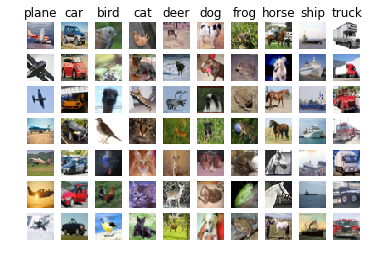

In [8]:
# Hiển thị một số ảnh từ trong bộ dữ liệu.
# Với mỗi lớp, chúng ta sẽ hiển thị một số ảnh minh họa.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [9]:
# Preprocessing data
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# Convert class labels to binary class labels
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# Explicitly split the training and validation sets
X_val = X_train[49000:]
y_val = y_train[49000:]
X_train = X_train[:49000]
y_train = y_train[:49000]

In [10]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [11]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [12]:
# Hyperparameters
conv_depth_1 = 48
conv_depth_2 = 96
conv_depth_3 = 192
batch_size = 128
num_epochs = 5
kernel_size = 3
pool_size = 2
drop_prob_1 = 0.25
drop_prob_2 = 0.25
drop_prob_3 = 0.25
drop_prob_4 = 0.5
drop_prob_5 = 0.5
hidden_size_1 = 512
hidden_size_2 = 256
l2_lambda = 0.0001
ens_models = 3

In [13]:
# Define the model
inp = Input(shape=(height, width, depth))
inp_norm = BatchNormalization()(inp)

outs = []
for i in range(ens_models):
    # 1
    conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', kernel_initializer='he_uniform', 
                           kernel_regularizer=l2(l2_lambda), activation='relu')(inp_norm)
    conv_1 = BatchNormalization()(conv_1)
    conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), kernel_initializer='he_uniform', 
                           kernel_regularizer=l2(l2_lambda), activation='relu')(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
    drop_1 = Dropout(drop_prob_1)(pool_1)
    
    # 2
    conv_3 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', kernel_initializer='he_uniform', 
                           kernel_regularizer=l2(l2_lambda), activation='relu')(drop_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_4 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), kernel_initializer='he_uniform', 
                           kernel_regularizer=l2(l2_lambda), activation='relu')(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
    drop_2 = Dropout(drop_prob_2)(pool_2)
    
    # 3
    conv_5 = Convolution2D(conv_depth_3, (kernel_size, kernel_size), padding='same', kernel_initializer='he_uniform', 
                           kernel_regularizer=l2(l2_lambda), activation='relu')(drop_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_6 = Convolution2D(conv_depth_3, (kernel_size, kernel_size), kernel_initializer='he_uniform', 
                           kernel_regularizer=l2(l2_lambda), activation='relu')(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    pool_3 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_6)
    drop_3 = Dropout(drop_prob_3)(pool_3)
    
    flat = Flatten()(drop_3)
    hidden_1 = Dense(hidden_size_1, kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda), activation='relu')(flat)
    hidden_1 = BatchNormalization()(hidden_1)
    drop_4 = Dropout(drop_prob_4)(hidden_1)
    
    hidden_2 = Dense(hidden_size_2, kernel_initializer='he_uniform',
                    kernel_regularizer=l2(l2_lambda), activation='relu')(drop_4)
    hidden_2 = BatchNormalization()(hidden_2)
    drop_5 = Dropout(drop_prob_5)(hidden_2)
    
    outs.append(Dense(num_classes, 
        kernel_initializer='glorot_uniform', 
        kernel_regularizer=l2(l2_lambda), 
        activation='softmax')(drop_5))

out = average(outs)
    
model = Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 48)   1344        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 48)   1344        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_13 

conv2d_17 (Conv2D)              (None, 6, 6, 192)    166080      dropout_12[0][0]                 
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 6, 6, 192)    768         conv2d_5[0][0]                   
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 6, 6, 192)    768         conv2d_11[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 6, 6, 192)    768         conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 4, 4, 192)    331968      batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv2d_12 

Total params: 3,534,522
Trainable params: 3,525,876
Non-trainable params: 8,646
__________________________________________________________________________________________________


In [14]:
# # Data Augmentation
# datagen = ImageDataGenerator(zoom_range=0.2, 
#                              horizontal_flip=True)

# datagen.fit(X_train)

# # Train
# model_info = model.fit_generator(datagen.flow(X_train, y_train,
#                         batch_size=batch_size),
#                         steps_per_epoch=X_train.shape[0],
#                         epochs=num_epochs,
#                         validation_data=(X_val, y_val),
#                         verbose=1,
#                         callbacks=[EarlyStopping(monitor='val_loss', patience=5)]) # adding early stopping

In [15]:
# Train
model_info = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        validation_data=(X_val, y_val),
                        verbose=1)
#                         callbacks=[EarlyStopping(monitor='val_loss', patience=5)]) # adding early stopping

Train on 49000 samples, validate on 1000 samples
Epoch 1/5
49000/49000 [==============================] - 4178s 85ms/step - loss: 2.6254 - acc: 0.3848 - val_loss: 2.5717 - val_acc: 0.4080
Epoch 2/5
49000/49000 [==============================] - 4153s 85ms/step - loss: 2.1614 - acc: 0.5458 - val_loss: 2.0253 - val_acc: 0.5870
Epoch 3/5
49000/49000 [==============================] - 4127s 84ms/step - loss: 1.8952 - acc: 0.6267 - val_loss: 1.8350 - val_acc: 0.6460
Epoch 4/5
49000/49000 [==============================] - 4215s 86ms/step - loss: 1.6970 - acc: 0.6828 - val_loss: 1.6081 - val_acc: 0.7110
Epoch 5/5
49000/49000 [==============================] - 4243s 87ms/step - loss: 1.5375 - acc: 0.7226 - val_loss: 1.4444 - val_acc: 0.7330


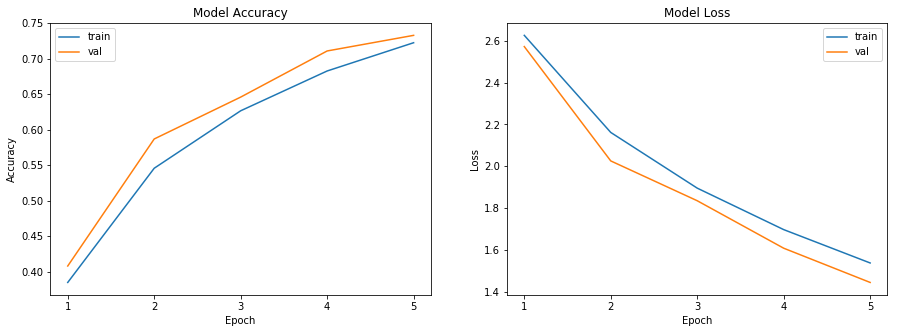

In [16]:
# Plot model history
plot_model_history(model_info)

In [18]:
# Evaluate the trained model on the test set!
model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 180s 18ms/step


[1.4799408885955811, 0.7315]

In [24]:
model.save('/home/lntk/Desktop/CIFAR10/cifar10_tuned_model.h5')